[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mezanass/seg_app/blob/master/training/Image_Segmentation.ipynb)

#Prepare the dataset

##Import dependencies & mount drive

In [1]:
import os
import functools
import collections

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (15,15)
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image

import cv2

import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

  from google.colab import drive
  drive.mount('/content/drive')

IndentationError: ignored

##Copy the dataset_folder & regions_csv_file & create the mask_folder

In [0]:
!rm -r squared_dataset
!rm -r squared_mask
!rm -r models
!rm via_region_data.csv

!cp -r /content/drive/My\ Drive/Image_Segmentation/squared_dataset /content/squared_dataset
!cp -r /content/drive/My\ Drive/Image_Segmentation/squared_mask /content/squared_mask
!cp -r /content/drive/My\ Drive/Image_Segmentation/models /content/models
!cp /content/drive/My\ Drive/Image_Segmentation/via_region_data.csv /content/via_region_data.csv
#!mkdir squared_mask
#!mkdir models
!ls squared_dataset
!ls squared_mask
!ls models
!ls

rm: cannot remove 'squared_dataset': No such file or directory
rm: cannot remove 'squared_mask': No such file or directory
rm: cannot remove 'models': No such file or directory
rm: cannot remove 'via_region_data.csv': No such file or directory
IMG_7019.JPG  IMG_7035.JPG  IMG_7051.JPG  IMG_7067.JPG	IMG_7120.JPG
IMG_7020.JPG  IMG_7036.JPG  IMG_7052.JPG  IMG_7068.JPG	IMG_7131.JPG
IMG_7021.JPG  IMG_7037.JPG  IMG_7053.JPG  IMG_7069.JPG	IMG_7132.JPG
IMG_7022.JPG  IMG_7038.JPG  IMG_7054.JPG  IMG_7071.JPG	IMG_7133.JPG
IMG_7023.JPG  IMG_7039.JPG  IMG_7055.JPG  IMG_7073.JPG	IMG_7134.JPG
IMG_7024.JPG  IMG_7040.JPG  IMG_7056.JPG  IMG_7076.JPG	IMG_7135.JPG
IMG_7025.JPG  IMG_7041.JPG  IMG_7057.JPG  IMG_7077.JPG	IMG_7136.JPG
IMG_7026.JPG  IMG_7042.JPG  IMG_7058.JPG  IMG_7078.JPG	IMG_7137.JPG
IMG_7027.JPG  IMG_7043.JPG  IMG_7059.JPG  IMG_7080.JPG	IMG_7138.JPG
IMG_7028.JPG  IMG_7044.JPG  IMG_7060.JPG  IMG_7083.JPG	IMG_7139.JPG
IMG_7029.JPG  IMG_7045.JPG  IMG_7061.JPG  IMG_7089.JPG	IMG_7140.JPG
IMG_7030

##Read the regions_csv_file & prepare the image and mask paths & the devide the train and test data

In [0]:
regions_file ='via_region_data.csv'
img_folder ='squared_dataset'
mask_folder ='squared_mask'
regions_data = pd.read_csv(regions_file)

img_names =regions_data['filename'].map(lambda s: os.path.join(img_folder, s))
img_names =list(collections.Counter(img_names).keys())

mask_names =regions_data['filename'].map(lambda s: os.path.join(mask_folder, s.split('.')[0]+'_mask.JPG'))
mask_names =list(collections.Counter(mask_names).keys())
print('len(img_names): {} \nlen(mask_names): {} \nimg_names[:5]: {} \nmask_names[:5]: {}'.format(len(img_names), len(mask_names), img_names[:5], mask_names[:5]))

tr_img_names, ts_img_names, tr_mask_names, ts_mask_names =train_test_split(img_names, mask_names, test_size=.2, random_state=0)
print('\nlen(tr_img_names): {} \nlen(ts_img_names): {} \ntr_img_names[:5]: {} \ntr_mask_names[:5]: {} \nts_image_names[:5]: {} \nts_mask_names[:5]: {}'.format(len(tr_img_names), len(ts_img_names), tr_img_names[:5], tr_mask_names[:5], ts_img_names[:5], ts_mask_names[:5]))

len(img_names): 79 
len(mask_names): 79 
img_names[:5]: ['squared_dataset/IMG_7019.JPG', 'squared_dataset/IMG_7020.JPG', 'squared_dataset/IMG_7021.JPG', 'squared_dataset/IMG_7022.JPG', 'squared_dataset/IMG_7023.JPG'] 
mask_names[:5]: ['squared_mask/IMG_7019_mask.JPG', 'squared_mask/IMG_7020_mask.JPG', 'squared_mask/IMG_7021_mask.JPG', 'squared_mask/IMG_7022_mask.JPG', 'squared_mask/IMG_7023_mask.JPG']

len(tr_img_names): 63 
len(ts_img_names): 16 
tr_img_names[:5]: ['squared_dataset/IMG_7022.JPG', 'squared_dataset/IMG_7041.JPG', 'squared_dataset/IMG_7026.JPG', 'squared_dataset/IMG_7045.JPG', 'squared_dataset/IMG_7061.JPG'] 
tr_mask_names[:5]: ['squared_mask/IMG_7022_mask.JPG', 'squared_mask/IMG_7041_mask.JPG', 'squared_mask/IMG_7026_mask.JPG', 'squared_mask/IMG_7045_mask.JPG', 'squared_mask/IMG_7061_mask.JPG'] 
ts_image_names[:5]: ['squared_dataset/IMG_7068.JPG', 'squared_dataset/IMG_7046.JPG', 'squared_dataset/IMG_7049.JPG', 'squared_dataset/IMG_7112.JPG', 'squared_dataset/IMG_7064.JP

##Function to create a new mask or add a region to an existing mask

In [0]:
def create_mask(mask_file, pts, color_):
  img =cv2.imread(img_file)

  mask =np.zeros(img.shape, dtype = "uint8")
  cv2.fillPoly(mask, [pts], color=color_)
  cv2.imwrite(mask_file, mask)
  
def add_region(mask_file, pts, color_):
  mask =cv2.imread(mask_file)
  cv2.fillPoly(mask, [pts], color=color_)
  cv2.imwrite(mask_file, mask)

##Create the masks for the entire dataset

In [0]:
blue =(255, 0, 0) #anass
green =(0, 255, 0) #mustapha
red =(0, 0, 255) #hamza

for indx, row in regions_data.iterrows():
  dict_rsa =eval(row['region_shape_attributes'])
  pts =np.array(list(zip(dict_rsa['all_points_x'], dict_rsa['all_points_y'])))
  img_file =os.path.join(img_folder, row['filename'])
  mask_file =os.path.join(mask_folder, row['filename'].split('.')[0]+'_mask.JPG')
  
  if row['region_id'] ==0:
    color =blue
  elif row['region_id'] ==1:
    color =green
  else:
    color =red
  
  if os.path.isfile(mask_file):
    print('open {} and add region'.format(mask_file))
    add_region(mask_file, pts, color)   
  else:
    print('\nopen {}'.format(img_file))
    create_mask(mask_file, pts, color)

##Flip some masks & copy the mask_folder to drive

In [0]:
flip_masks =['squared_mask/IMG_7064_mask.JPG', 'squared_mask/IMG_7065_mask.JPG', 'squared_mask/IMG_7066_mask.JPG', 'squared_mask/IMG_7067_mask.JPG', 'squared_mask/IMG_7068_mask.JPG', 'squared_mask/IMG_7069_mask.JPG', 'squared_mask/IMG_7071_mask.JPG', 'squared_mask/IMG_7073_mask.JPG', 'squared_mask/IMG_7076_mask.JPG', 'squared_mask/IMG_7077_mask.JPG', 'squared_mask/IMG_7078_mask.JPG', 'squared_mask/IMG_7080_mask.JPG', 'squared_mask/IMG_7083_mask.JPG', 'squared_mask/IMG_7089_mask.JPG', 'squared_mask/IMG_7092_mask.JPG', 'squared_mask/IMG_7101_mask.JPG', 'squared_mask/IMG_7104_mask.JPG', 'squared_mask/IMG_7108_mask.JPG', 'squared_mask/IMG_7112_mask.JPG']

for mask_path in flip_masks:
  mask =cv2.imread(mask_path)
  mask =cv2.flip(mask, 1)
  cv2.imwrite(mask_path, mask)

In [0]:
!cp -r /content/squared_mask /content/drive/My\ Drive/Image_Segmentation/squared_mask
#!cp -r /content/squared_dataset /content/drive/My\ Drive/Image_Segmentation/squared_dataset

!ls squared_mask
!ls

IMG_7019_mask.JPG  IMG_7039_mask.JPG  IMG_7059_mask.JPG  IMG_7101_mask.JPG
IMG_7020_mask.JPG  IMG_7040_mask.JPG  IMG_7060_mask.JPG  IMG_7104_mask.JPG
IMG_7021_mask.JPG  IMG_7041_mask.JPG  IMG_7061_mask.JPG  IMG_7108_mask.JPG
IMG_7022_mask.JPG  IMG_7042_mask.JPG  IMG_7062_mask.JPG  IMG_7112_mask.JPG
IMG_7023_mask.JPG  IMG_7043_mask.JPG  IMG_7063_mask.JPG  IMG_7120_mask.JPG
IMG_7024_mask.JPG  IMG_7044_mask.JPG  IMG_7064_mask.JPG  IMG_7131_mask.JPG
IMG_7025_mask.JPG  IMG_7045_mask.JPG  IMG_7065_mask.JPG  IMG_7132_mask.JPG
IMG_7026_mask.JPG  IMG_7046_mask.JPG  IMG_7066_mask.JPG  IMG_7133_mask.JPG
IMG_7027_mask.JPG  IMG_7047_mask.JPG  IMG_7067_mask.JPG  IMG_7134_mask.JPG
IMG_7028_mask.JPG  IMG_7048_mask.JPG  IMG_7068_mask.JPG  IMG_7135_mask.JPG
IMG_7029_mask.JPG  IMG_7049_mask.JPG  IMG_7069_mask.JPG  IMG_7136_mask.JPG
IMG_7030_mask.JPG  IMG_7050_mask.JPG  IMG_7071_mask.JPG  IMG_7137_mask.JPG
IMG_7031_mask.JPG  IMG_7051_mask.JPG  IMG_7073_mask.JPG  IMG_7138_mask.JPG
IMG_7032_mask.JPG  IMG_70

##Show an image and it's mask

squared_mask/IMG_7058_mask.JPG


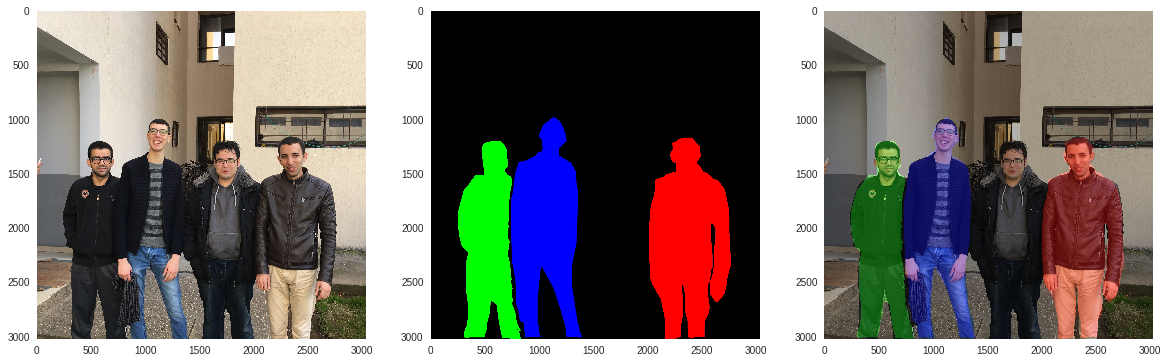

In [0]:
def show_img_mask(img_file):
  mask_file =os.path.join(mask_folder, img_file.split('/')[1].split('.')[0]+'_mask.JPG')
  print(mask_file)

  img =cv2.imread(img_file)
  img =cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask =cv2.imread(mask_file)
  mask =cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
  blend =cv2.addWeighted(img, .7, mask, .3, .0)
  
  plt.figure(figsize=(20, 20))
  plt.subplot(1, 3, 1)
  plt.imshow(img)
  plt.subplot(1, 3, 2)
  plt.imshow(mask)
  plt.subplot(1, 3, 3)
  plt.imshow(blend)
  
show_img_mask('squared_dataset/IMG_7058.JPG')

#Create the data pipeline

##Training parameters

In [0]:
img_shape =(256, 256, 3)
batch_size =3
epochs =30

##Data augmentation functions

In [0]:
def read_img_mask(img_path, mask_path):
  img_bf =tf.read_file(img_path)
  img =tf.image.decode_jpeg(img_bf, channels =3)
  
  mask_bf =tf.read_file(mask_path)
  mask =tf.image.decode_jpeg(mask_bf, channels=3)
  
  return img, mask

def shift_img_mask(img, mask, width_shift_range, height_shift_range):
  if width_shift_range or height_shift_range:
    if width_shift_range:
      width_shift_range =tf.random_uniform([], -width_shift_range*img_shape[1], width_shift_range*img_shape[1])
    
    if height_shift_range:
      height_shift_range =tf.random_uniform([], -height_shift_range*img_shape[0], height_shift_range*img_shape[0])
      
    img =tfcontrib.image.translate(img, [width_shift_range, height_shift_range])
    mask =tfcontrib.image.translate(mask, [width_shift_range, height_shift_range])
    
  return img, mask
      
def flip_img_mask(img, mask, horizontal_flip):
  flip_prob =tf.random_uniform([], 0.0, 1.0)
  img, mask = tf.cond(tf.less(flip_prob, .5), lambda: (tf.image.flip_left_right(img), tf.image.flip_left_right(mask)), lambda: (img, mask))
  
  return img, mask

def augment(img, mask, resize=None, scale=1, hue_delta=0, horizontal_flip=False, width_shift_range=0, height_shift_range=0):
  if resize is not None:
    img =tf.image.resize_images(img, resize)
    mask =tf.image.resize_images(mask, resize)
  if hue_delta:
    img =tf.image.random_hue(img, hue_delta)
  img, mask =flip_img_mask(img, mask, horizontal_flip)
  img, mask =shift_img_mask(img, mask, width_shift_range, height_shift_range)
  img =tf.to_float(img)*scale
  mask =tf.to_float(mask)*scale
  return img, mask

def get_dataset(img_names, mask_names, preproc_fn=functools.partial(augment), batch_size=batch_size, shuffle=True):
  num_img =len(img_names)
  
  dataset =tf.data.Dataset.from_tensor_slices((img_names, mask_names))
  dataset =dataset.map(read_img_mask, num_parallel_calls=5)
  dataset =dataset.map(preproc_fn, num_parallel_calls=5)
  
  if shuffle:
    dataset =dataset.shuffle(num_img)
    
  dataset =dataset.repeat().batch(batch_size)
  
  return dataset

tr_cfg ={'width_shift_range': .1, 'height_shift_range': .1, 'resize': [img_shape[0], img_shape[1]], 'scale': 1/255, 'hue_delta': .1, 'horizontal_flip': True}
tr_preproc_fn =functools.partial(augment, **tr_cfg)

ts_cfg ={'resize': [img_shape[0], img_shape[1]], 'scale': 1/255}
ts_preproc_fn =functools.partial(augment, **ts_cfg)



##create a tr_dataset & ts_dataset

In [0]:
tr_dataset =get_dataset(tr_img_names, tr_mask_names, preproc_fn=tr_preproc_fn)
ts_dataset =get_dataset(ts_img_names, ts_mask_names, preproc_fn=ts_preproc_fn)

print(tr_dataset, '\n', ts_dataset)

<BatchDataset shapes: ((?, 256, 256, 3), (?, 256, 256, 3)), types: (tf.float32, tf.float32)> 
 <BatchDataset shapes: ((?, 256, 256, 3), (?, 256, 256, 3)), types: (tf.float32, tf.float32)>


##Visualize the effect of the augmentation

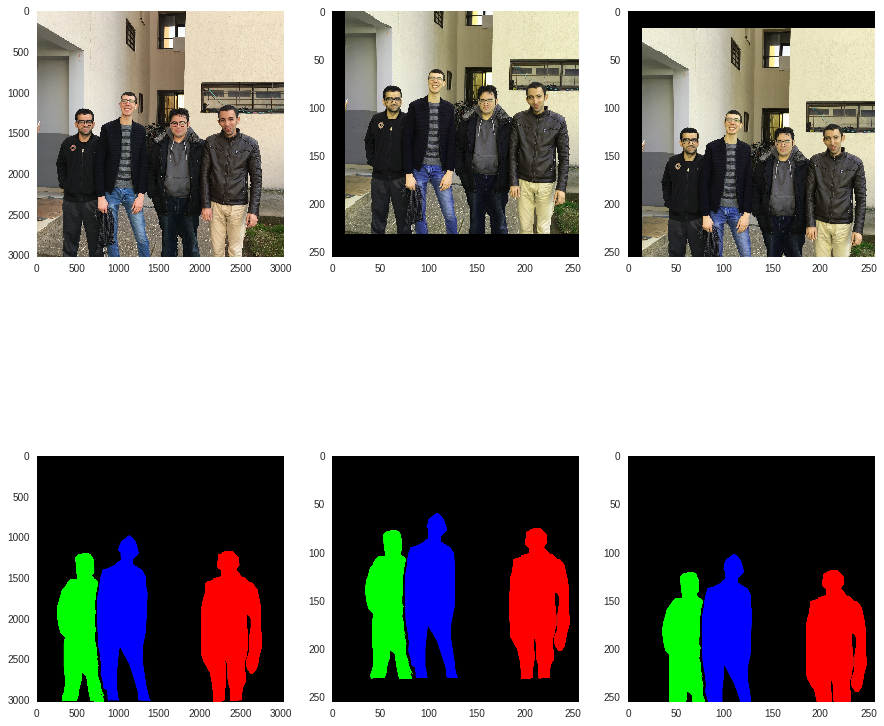

In [0]:
with tf.Session() as sess:
  img, mask =sess.run(read_img_mask('squared_dataset/IMG_7058.JPG', 'squared_mask/IMG_7058_mask.JPG'))
  img1, mask1 =sess.run(augment(img, mask, resize=[img_shape[0], img_shape[1]], scale=1/255, hue_delta=.1, horizontal_flip=True, width_shift_range=.1, height_shift_range=.1))
  img2, mask2 =sess.run(augment(img, mask, resize=[img_shape[0], img_shape[1]], scale=1/255, hue_delta=.1, horizontal_flip=True, width_shift_range=.1, height_shift_range=.1))

  plt.subplot(2, 3, 1)
  plt.imshow(img)
  plt.subplot(2, 3, 4)
  plt.imshow(mask)
  
  plt.subplot(2, 3, 2)
  plt.imshow(img1)
  plt.subplot(2, 3, 5)
  plt.imshow(mask1)
  
  plt.subplot(2, 3, 3)
  plt.imshow(img2)
  plt.subplot(2, 3, 6)
  plt.imshow(mask2)
  
  

#Create a model

##encoder_block & conv_block & decoder_block functions

In [0]:
def conv_block(input_tensor, num_filters):
  encoder =layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder =layers.BatchNormalization()(encoder)
  encoder =layers.Activation('relu')(encoder)
  encoder =layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder =layers.BatchNormalization()(encoder)
  encoder =layers.Activation('relu')(encoder)
  
  return encoder 

def encoder_block(input_tensor, num_filters):
  encoder =layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder =layers.BatchNormalization()(encoder)
  encoder =layers.Activation('relu')(encoder)
  encoder =layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder =layers.BatchNormalization()(encoder)
  encoder =layers.Activation('relu')(encoder)
  encoder_pool =layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder, encoder_pool

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder =layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), 
                                  padding='same')(input_tensor)
  decoder =layers.concatenate([decoder, concat_tensor], axis=-1)
  decoder =layers.BatchNormalization()(decoder)
  decoder =layers.Activation('relu')(decoder)
  decoder =layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder =layers.BatchNormalization()(decoder)
  decoder =layers.Activation('relu')(decoder)
  decoder =layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder =layers.BatchNormalization()(decoder)
  decoder =layers.Activation('relu')(decoder)
  
  return decoder

##define the U-Net autoencoder architecture

In [0]:
inputs =layers.Input(shape=img_shape) #256

encoder0, encoder0_pool =encoder_block(inputs, 32) #128
encoder1, encoder1_pool =encoder_block(encoder0_pool, 64) #64
encoder2, encoder2_pool =encoder_block(encoder1_pool, 128) #32
encoder3, encoder3_pool =encoder_block(encoder2_pool, 256) #16
encoder4, encoder4_pool =encoder_block(encoder3_pool, 512) #8

center =conv_block(encoder4_pool, 1024) #8

decoder4 =decoder_block(center, encoder4, 512) #16
decoder3 =decoder_block(decoder4, encoder3, 256) #32
decoder2 =decoder_block(decoder3, encoder2, 128) #64
decoder1 =decoder_block(decoder2, encoder1, 64) #128
decoder0 =decoder_block(decoder1, encoder0, 32) #256

outputs =layers.Conv2D(3, (1, 1), activation='sigmoid')(decoder0) #activation to be determined maybe use softmax

model =models.Model(inputs=[inputs], outputs=[outputs])

##define the ANN autoencoder architecture

In [0]:
model =models.Sequential()
model.add(layers.Flatten(input_shape=img_shape))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(196608, activation='sigmoid'))
model.add(layers.Reshape(img_shape))
 

##define loss function & compile the model

In [0]:
def dice_coeff(y_true, y_pred):
  smooth = 1.
  y_true_f =tf.cast(tf.reshape(y_true, [-1]), tf.float32)
  y_pred_f =tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
  intersection = tf.reduce_sum(y_true_f * y_pred_f)
  score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
  
  return score

def mse_loss(y_true, y_pred):
  y_true =tf.cast(y_true, tf.float32)
  y_pred =tf.cast(y_pred, tf.float32)
  loss =tf.reduce_mean(tf.pow(tf.reshape(y_true, shape=[-1, 1]) - tf.reshape(y_pred, shape=[-1, 1]), 2)) * 100
  
  return loss

def loss_tmp(y_true, y_pred):
  y_true =tf.cast(y_true, tf.float32)
  y_pred =tf.cast(y_pred, tf.float32)
  loss =tf.reduce_mean(tf.pow(tf.reshape(y_true, shape=[-1, 1]) - tf.reshape(y_pred, shape=[-1, 1]), 2)) * 100
  
  return loss

def ce_loss(y_true, y_pred):
  y_true_f =tf.cast(tf.reshape(y_true, [-1]), tf.float32)
  y_pred_f =tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
  loss = -tf.reduce_sum(y_true_f*tf.log(tf.clip_by_value(y_pred_f,1e-10,1.0)))
  
  return loss

def ce_dice_loss(y_true, y_pred):
  loss =ce_loss(y_true, y_pred) +1-dice_coeff(y_true, y_pred)
  
  return loss
 


model.compile(optimizer=tf.train.AdamOptimizer(), loss=mse_loss, metrics=[dice_coeff])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 196608)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              201327616 
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              263168    
_________________________________________________________________
dense_3 (Dense)              (None, 196608)            201523200 
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 3)       0         
Total params: 403,376,384
Trainable params: 403,376,384
Non-trainable params: 0
______________________________________________________________

In [0]:
with tf.Session() as sess:
  img, mask =sess.run(read_img_mask('squared_dataset/IMG_7048.JPG', 'squared_mask/IMG_7048_mask.JPG'))
  img2, mask2 =sess.run(read_img_mask('squared_dataset/IMG_7043.JPG', 'squared_mask/IMG_7043_mask.JPG'))
  
  dice =sess.run(mse_loss(mask, mask2))
  print(dice)

1431799.6


##start the training & save the model

In [0]:
save_model_path ='models/weights_ann_sigmoid_mse_loss.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_loss', save_best_only=True, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(tr_dataset, 
                   steps_per_epoch=int(np.ceil(len(tr_img_names) / float(batch_size))), 
                   epochs=epochs, 
                   validation_data=ts_dataset, 
                   validation_steps=int(np.ceil(len(ts_img_names) / float(batch_size))), 
                   callbacks=[cp])

Epoch 1/30
20/21 [===========================>..] - ETA: 0s - loss: 12.6878 - dice_coeff: 0.1025
Epoch 00001: val_loss improved from inf to 12.34789, saving model to models/weights_ann_sigmoid_mse_loss.hdf5
21/21 [==============================] - 20s 930ms/step - loss: 12.7196 - dice_coeff: 0.1041 - val_loss: 12.3479 - val_dice_coeff: 0.1200
Epoch 2/30
20/21 [===========================>..] - ETA: 0s - loss: 12.8291 - dice_coeff: 0.0972
Epoch 00002: val_loss did not improve from 12.34789
21/21 [==============================] - 9s 451ms/step - loss: 12.9457 - dice_coeff: 0.0990 - val_loss: 12.9833 - val_dice_coeff: 0.0827
Epoch 3/30
20/21 [===========================>..] - ETA: 0s - loss: 12.7252 - dice_coeff: 0.1079
Epoch 00003: val_loss did not improve from 12.34789
21/21 [==============================] - 9s 448ms/step - loss: 12.7709 - dice_coeff: 0.1084 - val_loss: 13.4928 - val_dice_coeff: 0.1148
Epoch 4/30
20/21 [===========================>..] - ETA: 0s - loss: 12.7991 - dice_

#Visualize the training process

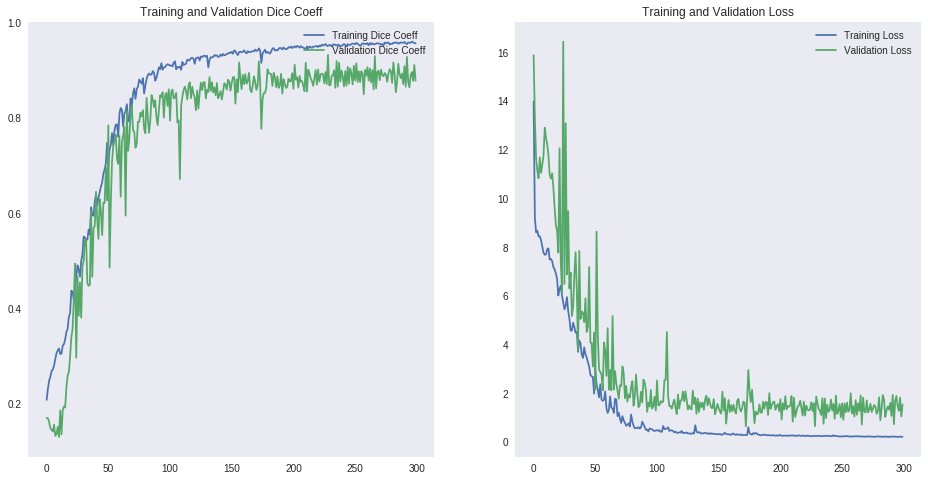

In [0]:
dice_coeff_ = history.history['dice_coeff']
val_dice_coeff = history.history['val_dice_coeff']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice_coeff_, label='Training Dice Coeff')
plt.plot(epochs_range, val_dice_coeff, label='Validation Dice Coeff')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Coeff')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [0]:
!ls models/
#!cp -r models /content/drive/My\ Drive/Image_Segmentation/models
save_model_path ='models/weights_sigmoid_mse_loss.hdf5'
model =models.load_model(save_model_path, custom_objects={'dice_coeff': dice_coeff, 'mse_loss': mse_loss})

weights_elu_loss_tmp.hdf5      weights_sigmoid_mse_loss.hdf5
weights_relu_loss_tmp.hdf5     weights_sigmoid_mse_loss_js
weights_relu_loss_tmp_js       weights_softmax_loss_tmp.hdf5
weights_sigmoid_loss_tmp.hdf5


#Evaluate the model

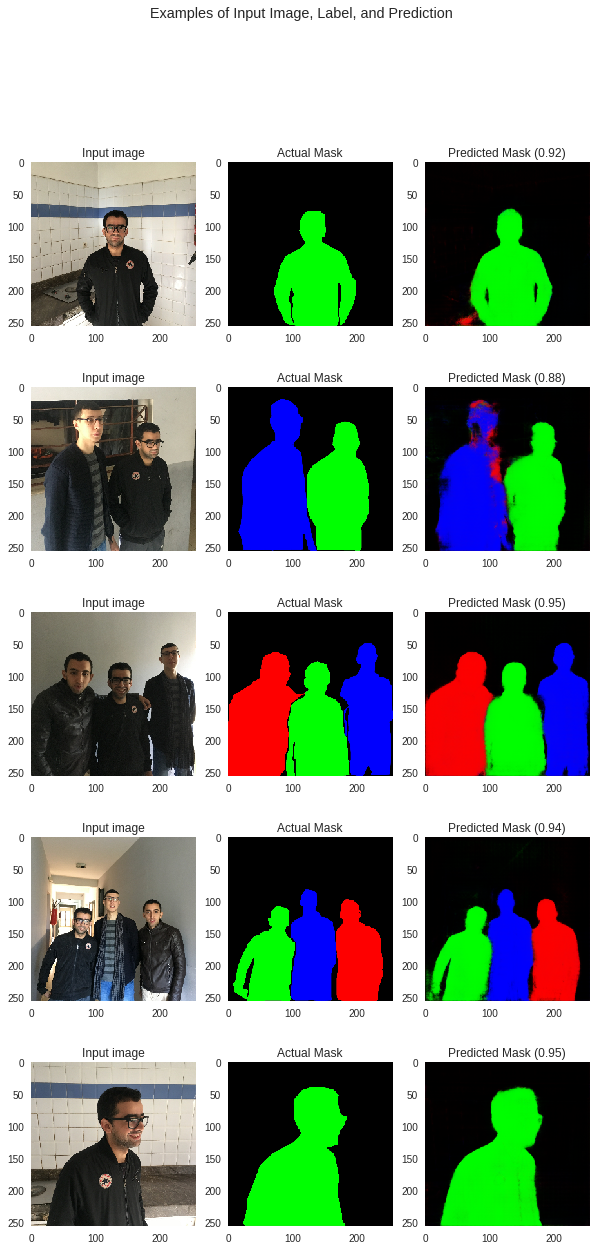

In [0]:
# Let's visualize some of the outputs 
data_aug_iter = ts_dataset.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img =batch_of_imgs[0]
  label =label[0]
  predicted_label =model.predict(batch_of_imgs)[0]
  dice =tf.keras.backend.get_session().run(dice_coeff(label, predicted_label))

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img)
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label)
  plt.title("Actual Mask")
  
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label)
  plt.title("Predicted Mask ({:.2f})".format(dice))
  
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()

Saving test_img.JPG to test_img.JPG


Text(0.5,1,'Predicted Mask')

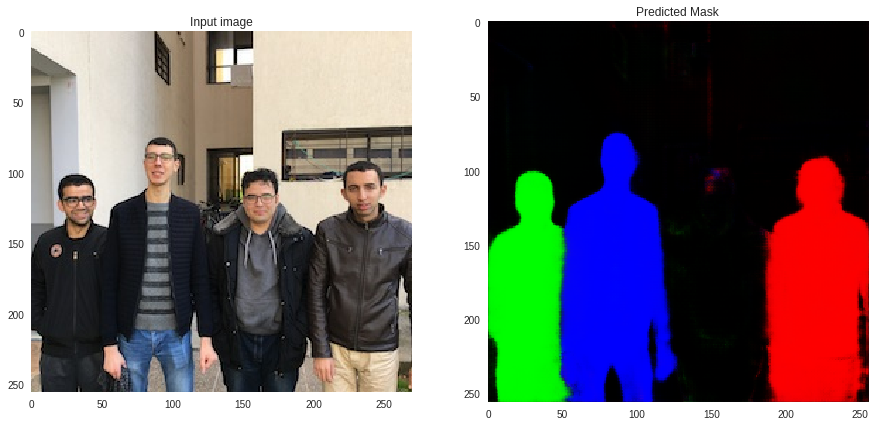

In [0]:
test_img ='test_img.JPG'
test_mask ='test_mask.JPG'

from google.colab import files
uploaded = files.upload()
if test_img in uploaded:
  with open(test_img, "wb") as f:
      f.write(uploaded[test_img])

with tf.Session() as sess:  
  img_bf =sess.run(tf.read_file(test_img))
  img =sess.run(tf.image.decode_jpeg(img_bf, channels =3))
  img_rs =sess.run(tf.to_float(tf.image.resize_images(img, [256, 256]))*1/255.)
  img_bs =sess.run(tf.expand_dims(img_rs, 0))

predict =model.predict(img_bs, steps=1)[0]
cv2.imwrite(test_mask, predict)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Input image")

plt.subplot(1, 2, 2)
plt.imshow(predict)
plt.title("Predicted Mask")


In [0]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras models/weights_sigmoid_mse_loss.hdf5 models/weights_sigmoid_mse_loss_js
!cp -r models/weights_sigmoid_mse_loss_js /content/drive/My\ Drive/Image_Segmentation/models/weights_sigmoid_mse_loss_js

    100% |████████████████████████████████| 61kB 5.8MB/s 
    100% |████████████████████████████████| 307kB 9.5MB/s 
    100% |████████████████████████████████| 13.9MB 3.0MB/s 
    100% |████████████████████████████████| 51kB 15.1MB/s 
tensorflow 1.12.0 has requirement keras-applications>=1.0.6, but you'll have keras-applications 1.0.4 which is incompatible.
tensorflow 1.12.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.0 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
cufflinks 0.14.6 has requirement plotly>=3.0.0, but you'll have plotly 1.12.12 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6
  Found existing installation: tensorflow-hub 0.2.0
    Uninstalling tensorflow-hub-0.2.0:
  

In [0]:
!cp  models/weights_sigmoid_mse_loss.hdf5 /content/drive/My\ Drive/Image_Segmentation/models/weights_sigmoid_mse_loss.hdf5

In [0]:
!ls

 drive	       squared_dataset	   test_img.JPG
 models        squared_mask	   test_mask.JPG
 sample_data  'test_img (1).JPG'   via_region_data.csv
